In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data_dir = "./../data/"

## Functions

### Loading

In [7]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (biotoxins_ts["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]


### Imputation

In [8]:
def seasonal_mean(ts, n, lr=1):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

# linear, quadratic, cubic, knn, seasonal_year, seasonal_month 
def plot_imputations(ts, target, imputations, begin, end, n_neighbours=10):
    n = len(imputations)
    fig, ax = plt.subplots(n+1,1, figsize=(12,14), constrained_layout=True)
    
    imp = ts[target].interpolate(method="linear")
    imp.plot(ax=ax[0], style='-r')
    ts[target].plot(ax=ax[0], style='-b')
    ax[0].set_title("Example imputation")
    
    i = 1
    if "linear" in imputations:
        imp = ts[target].interpolate(method="linear")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Linear interpolation")
        i+=1
        
    if "quadratic" in imputations:
        imp = ts[target].interpolate(method="quadratic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Quadratic interpolation")
        i+=1
        
    if "cubic" in imputations:
        imp = ts[target].interpolate(method="cubic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Cubic interpolation")
        i+=1
        
    if "knn" in imputations:
        imp = pd.Series(data=knn_mean(ts[target], n_neighbours), index=ts[target].index)
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("KNN mean")
        i+=1
        
    if "seasonal_year" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=52)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (year) mean")
        i+=1
        
    if "seasonal_month" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=4)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (month) mean")
        i+=1
    
    plt.show()

### Seasonality

In [9]:
def plot_season_per(ts, by, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()

    if by.lower() == "w":
        code = '%W'
    elif by.lower() == "m":
        code = '%b'
        
    ts['per'] = [d.strftime(code) for d in ts.index]

    for i, y in enumerate(years):
        per_year = ts.loc[ts['year']==y]
        ax.plot('per', toxin, data=per_year, label=y, marker='o', markersize=3)
    
    ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    ax.legend()
    return ax

def plot_season_all(ts_list, areas, by, ax, toxin='dsp_toxins', hline=160, ci=False):
    ts_final_list=[]
    for i in range(len(ts_list)):
        ts = ts_list[i].copy()
        ts['year'] = [d.year for d in ts.index]
        years = ts['year'].unique()
        ts["area"] = areas[i]

        if by.lower() == "w":
            code = '%W'
        elif by.lower() == "m":
            code = '%b'

        ts['per'] = [d.strftime(code) for d in ts.index]
        ts_final_list.append(ts)

    final_ts = pd.concat(ts_final_list, ignore_index=True)
    if ci:
        sns.lineplot(data=final_ts, x="per", y=toxin, hue="area", ax=ax)
    else:
        sns.lineplot(data=final_ts, x="per", y=toxin, hue="area", ax=ax, ci=None)
        
    #ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    ax.legend()
    return ax

    
    
def boxplot_season_per(ts, by, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()

    if by.lower() == "w":
        code = '%W'
    elif by.lower() == "m":
        code = '%b'
        
    ts['per'] = [d.strftime(code) for d in ts.index]
    
    sns.boxplot(x='per', y=toxin, data=ts, ax=ax)
    ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax


def boxplot_season_all(ts_list, areas, by, ax, toxin='dsp_toxins', hline=160, merge_areas=True):
    ts_final_list=[]
    for i in range(len(ts_list)):
        ts = ts_list[i].copy()
        ts['year'] = [d.year for d in ts.index]
        years = ts['year'].unique()
        ts["area"] = areas[i]

        if by.lower() == "w":
            code = '%W'
        elif by.lower() == "m":
            code = '%b'

        ts['per'] = [d.strftime(code) for d in ts.index]
        ts_final_list.append(ts)

    final_ts = pd.concat(ts_final_list, ignore_index=True)
    if merge_areas:
        sns.boxplot(data=final_ts, x="per", y=toxin, ax=ax)
    else:
        sns.boxplot(data=final_ts, x="per", y=toxin, hue="area", ax=ax)

    #ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    ax.legend()
    return ax

### Trend

In [10]:
def boxplot_trend(ts, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()
        
    ts['month'] = [d.strftime('%b') for d in ts.index]

    sns.boxplot(x='year', y=toxin, data=ts, ax=ax)
    ax.set_title(f"Per year", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

def plot_trend(ts, ax, toxin='dsp_toxins', max_year=2020, hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]

    ts = ts[ts['year']<=max_year]
    sns.lineplot(x='year', y=toxin, data=ts, ax=ax)
    ax.set_title(f"Per year", fontsize=16)
    #ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

def plot_trend_all(ts_list, areas, ax, toxin='dsp_toxins', max_year=2020, hline=160,ci=False):
    ts_final_list = []
    for i in range(len(ts_list)):
        ts = ts_list[i].copy()
        ts['year'] = [d.year for d in ts.index]
        ts = ts[ts['year']<=max_year]
        ts["area"] = areas[i]
        ts_final_list.append(ts)
        
    final_ts = pd.concat(ts_final_list, ignore_index=True)
    if ci:
        sns.lineplot(x='year', y=toxin,hue="area", data=final_ts, ax=ax)
    else:
        sns.lineplot(x='year', y=toxin,hue="area", data=final_ts, ax=ax, ci=None)

        
    ax.set_title(f"Per year", fontsize=16)
    #ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

### Decompose

In [11]:
def decompose(ts):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (10,8)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=14)
    result_add.plot().suptitle('Additive Decompose', fontsize=14)
    plt.show()

# Loading

![image](./images/ts_solutions.png)

![image](./images/regularize.png)

In [12]:
biotoxins = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', engine="openpyxl")

biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts

,Sample,Species,Sample_Point,Production_Area,dsp_toxins,asp_toxins,psp_toxins
Date,,,,,,,
2015-01-05,1,Mexilhão,Jangada,LAL,20.0,1.8,71.0
2015-01-05,20,Berbigão,Canal do Espinheiro,RIAV3,36.0,1.8,71.0
2015-01-05,19,Berbigão,Costa Nova,RIAV2,26.0,1.8,71.0
2015-01-05,18,Berbigão,Moacha,RIAV1,36.0,1.8,71.0
2015-01-05,17,Amêijoa-branca,Torreira,L3,36.0,1.8,71.0
...,...,...,...,...,...,...,...
2020-12-29,2211,Mexilhão,Povoação,POR2,36.0,1.8,NaN
2020-12-29,2212,Mexilhão,Aljezur,L7a,36.0,NaN,NaN
2020-12-29,2213,Mexilhão,Garganta,OLH4,36.0,NaN,NaN


# Comparison

In [13]:
areas = ["L2", "RIAV1", "RIAV2", "LOB", "L5b", "ETJ1", "L7c1", "OLH2", "LAG"]
regions = {"Norte": ["L2", "RIAV1", "RIAV2"], "Oeste": ["LOB", "L5b", "ETJ1"], "Sul": ["L7c1", "OLH2", "LAG"]}
species = "Mexilhão"

In [14]:
ts_week = []
ts_month = []
for area in areas:
    ts_week.append(get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W", plot=False))
    ts_month.append(get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M", plot=False))

Quando interpolado usando **week** a data representa o fim da semana

## Seasonality

### Separated - Line

2020 só NaN em Setembro, 1 valor para Outubro, NaN Novembro e 1 Dezembro

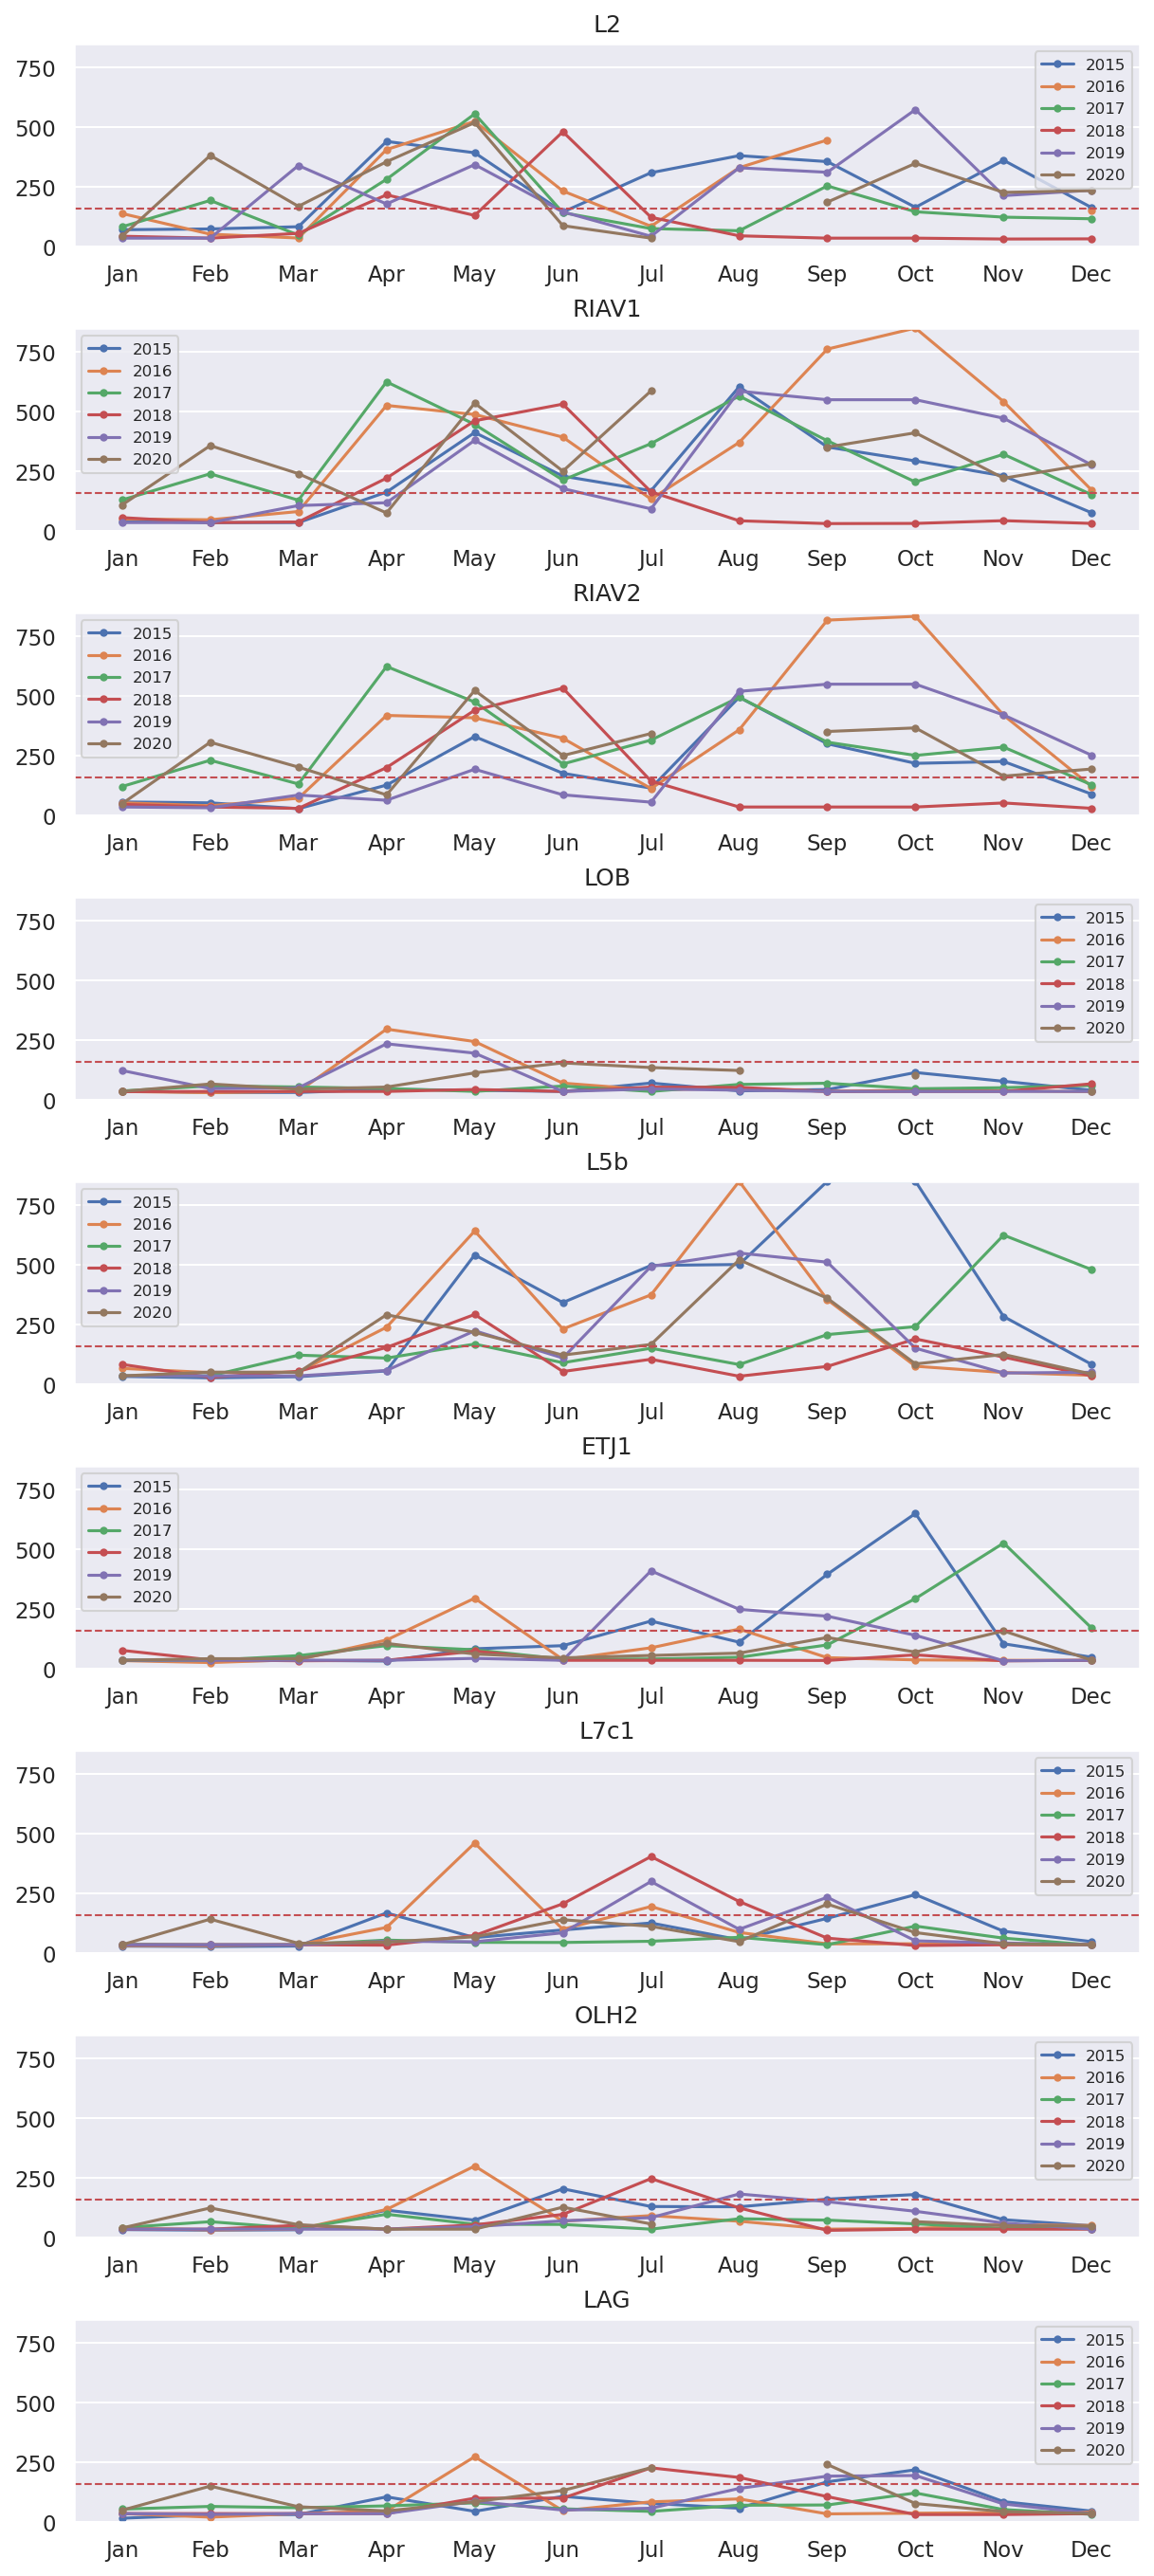

In [15]:
fig, axes = plt.subplots(len(ts_month),1, figsize=(8,18), constrained_layout=True)

for i in range(len(ts_month)):
    axes[i] = plot_season_per(ts_month[i], 'm', axes[i])
    axes[i].set_ylim(0,850)
    axes[i].set_title(areas[i])
    axes[i].legend(prop={'size': 8})
    
plt.show()

### All - Line

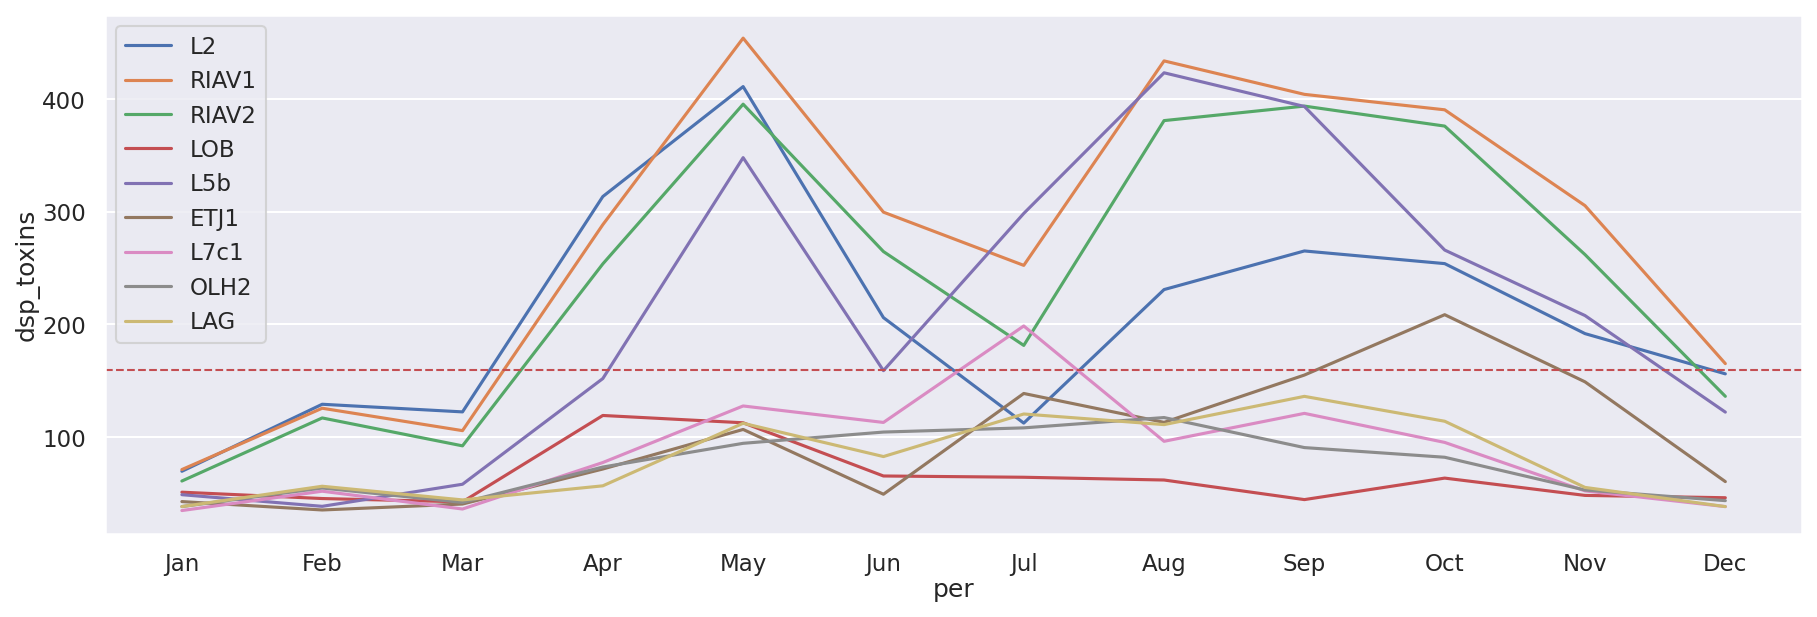

In [16]:
fig, axes = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
axes = plot_season_all(ts_month, areas, 'm', axes, ci=False)
plt.show()

### SuperAreas - Line

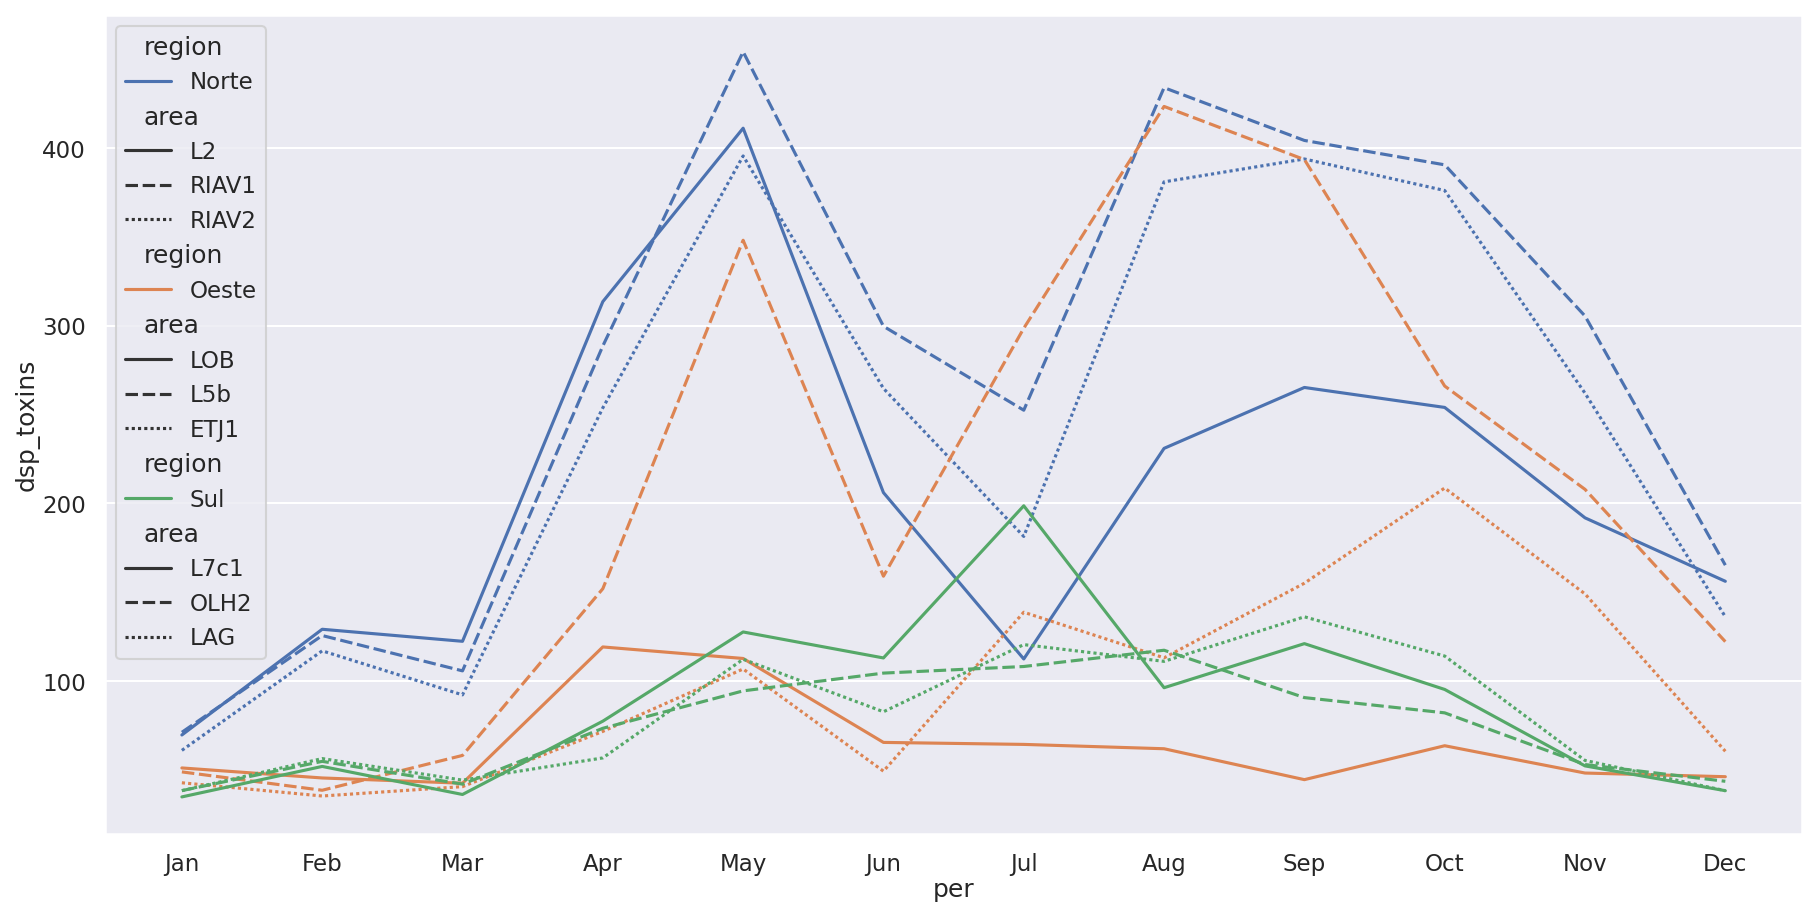

In [17]:
palette = sns.color_palette()

region_ts = pd.DataFrame(columns=ts_month[0].columns.tolist() + ["area","region"])
for ts, area in zip(ts_month, areas):
    t = ts.copy()
    t["area"] = area
    for r in regions:
        if area in regions[r]:
            t["region"] = r
    
    region_ts = region_ts.append(t)
region_ts['per'] = [d.strftime("%b") for d in region_ts.index]
region_ts = region_ts.reset_index(drop = True)


fig, ax = plt.subplots(1,1, figsize=(12,6), constrained_layout=True)
for i,region in enumerate(region_ts["region"].unique()):
    t = region_ts[region_ts["region"]==region]
    sns.lineplot(data=t, x="per", y="dsp_toxins", hue="region",style="area", ax=ax, ci=None, palette=[palette[i]])
    
plt.show()

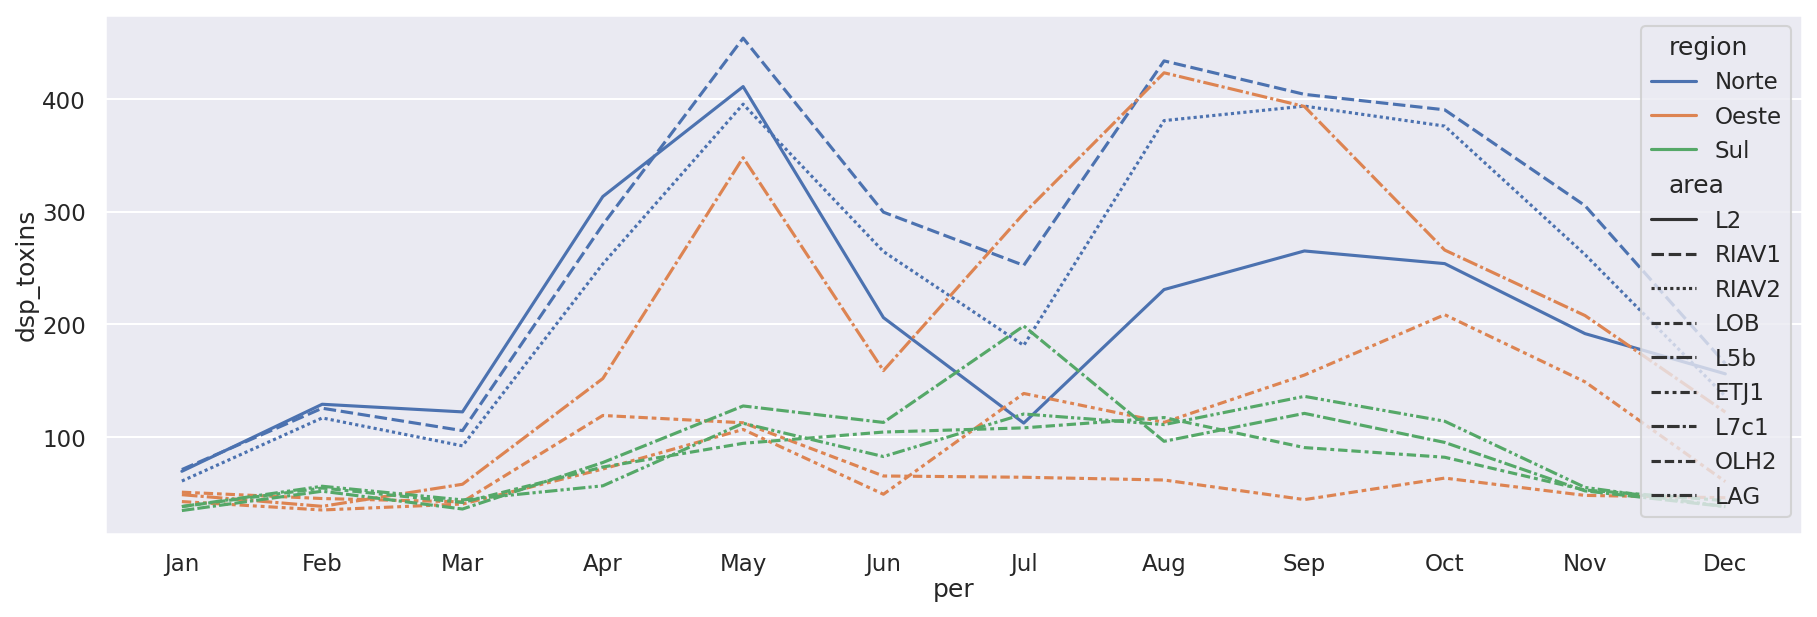

In [18]:
region_ts = pd.DataFrame(columns=ts_month[0].columns.tolist() + ["area","region"])
for ts, area in zip(ts_month, areas):
    t = ts.copy()
    t["area"] = area
    for r in regions:
        if area in regions[r]:
            t["region"] = r
    
    region_ts = region_ts.append(t)
region_ts['per'] = [d.strftime("%b") for d in region_ts.index]
region_ts = region_ts.reset_index(drop = True)


fig, ax = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
sns.lineplot(data=region_ts, x="per", y="dsp_toxins", hue="region", style="area",
             ax=ax, ci=None)
plt.show()

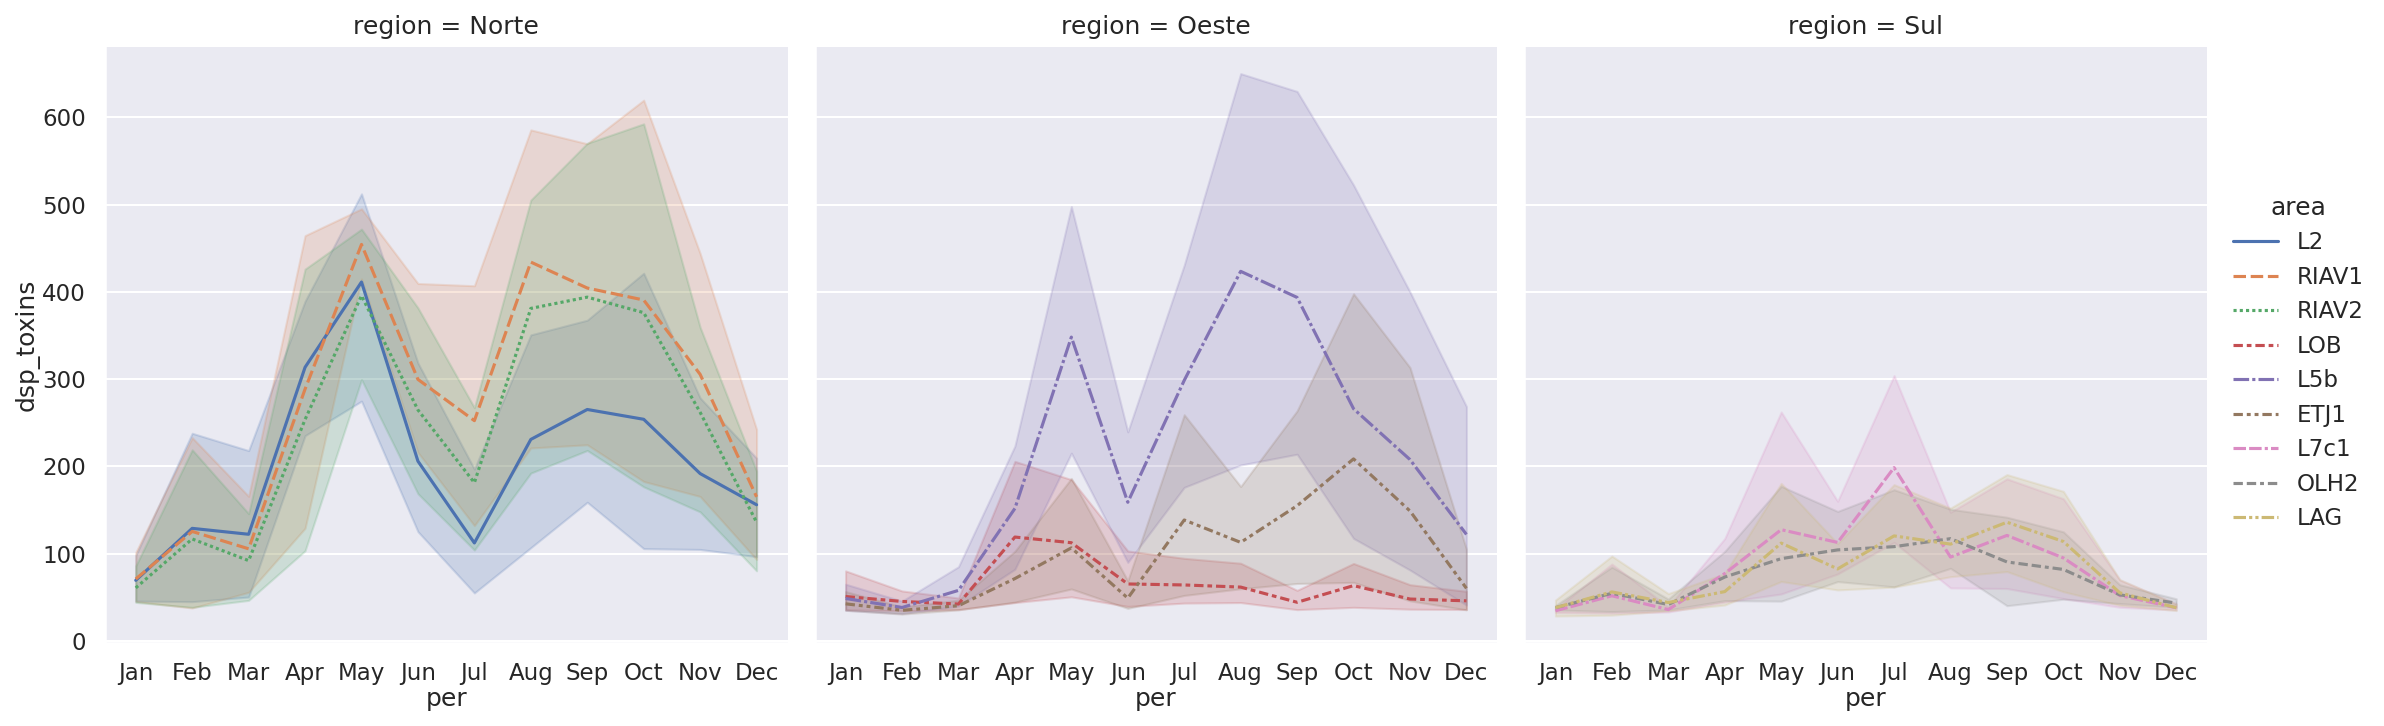

In [27]:
#palette = ["#5163FF", "#5F37E1", "#54BDE9", "#E9A954", "#E9DA54", "#D48050", "#3DE95F", "#A3CE4C", "#C1CE4C"]
#palette = ["#2a4d69", "#4b86b4", "#63ace5"] * 3

sns.relplot(
    data=region_ts, x="per", y="dsp_toxins",
    col="region", hue="area", style="area",
    kind="line"#, palette=palette
)
plt.show()

### Separated - Box

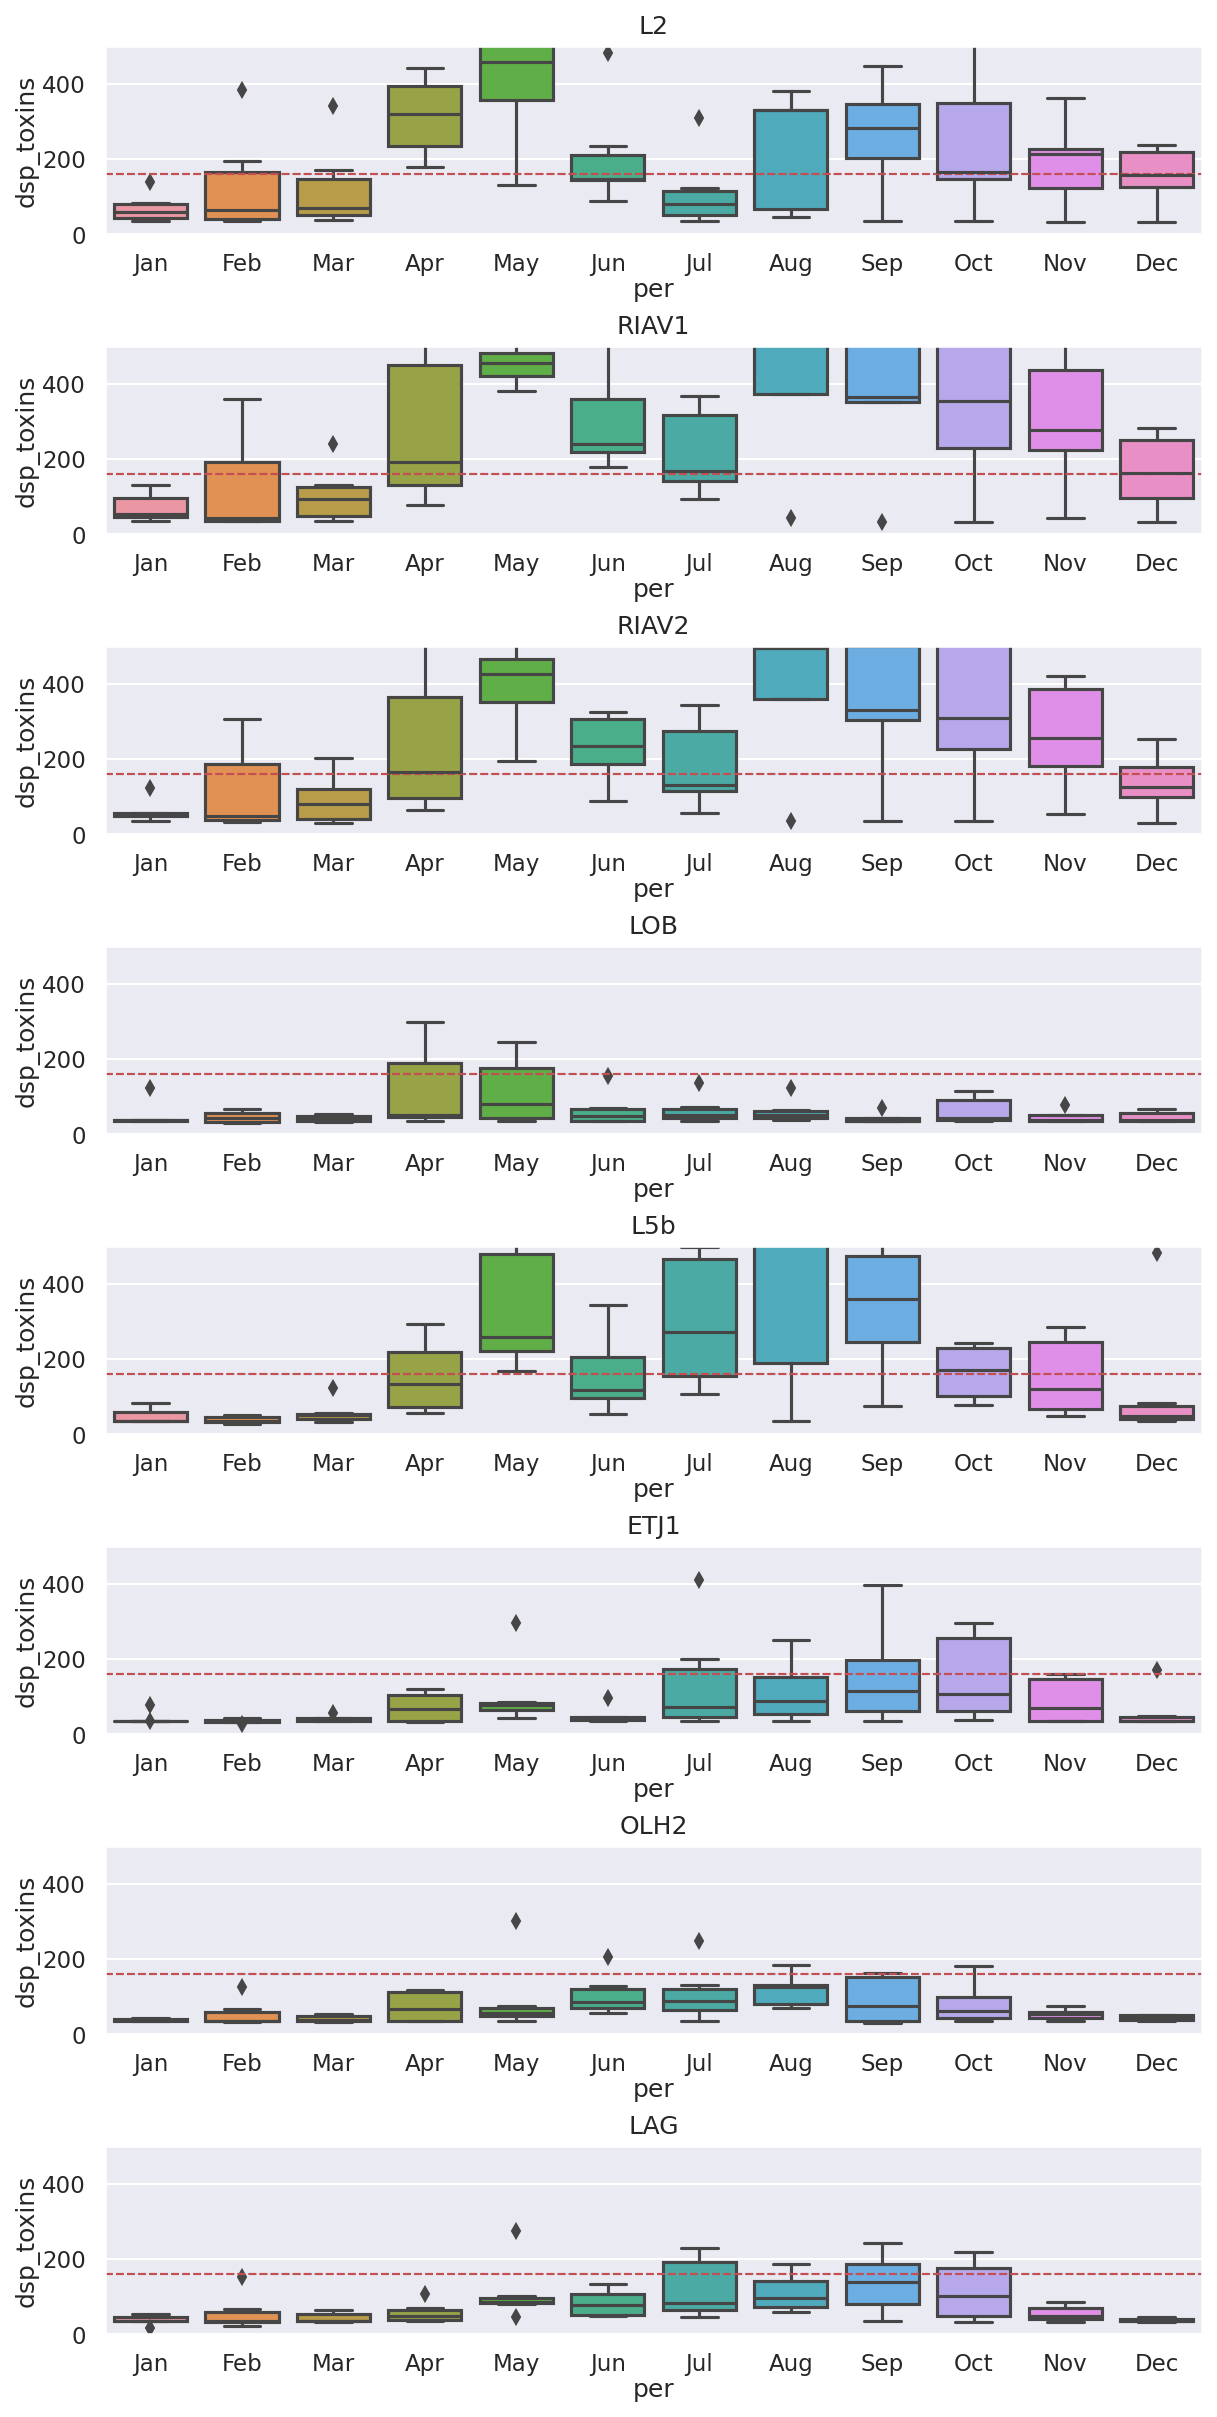

In [11]:
fig, axes = plt.subplots(len(ts_month),1, figsize=(8,16), constrained_layout=True)

for i in range(len(ts_month)):
    axes[i] = boxplot_season_per(ts_month[i], 'm', axes[i])
    axes[i].set_ylim(0,500)
    axes[i].set_title(areas[i])
    axes[i].axhline(160, linestyle="--", color="r", linewidth=1)


plt.show()

### All - Box

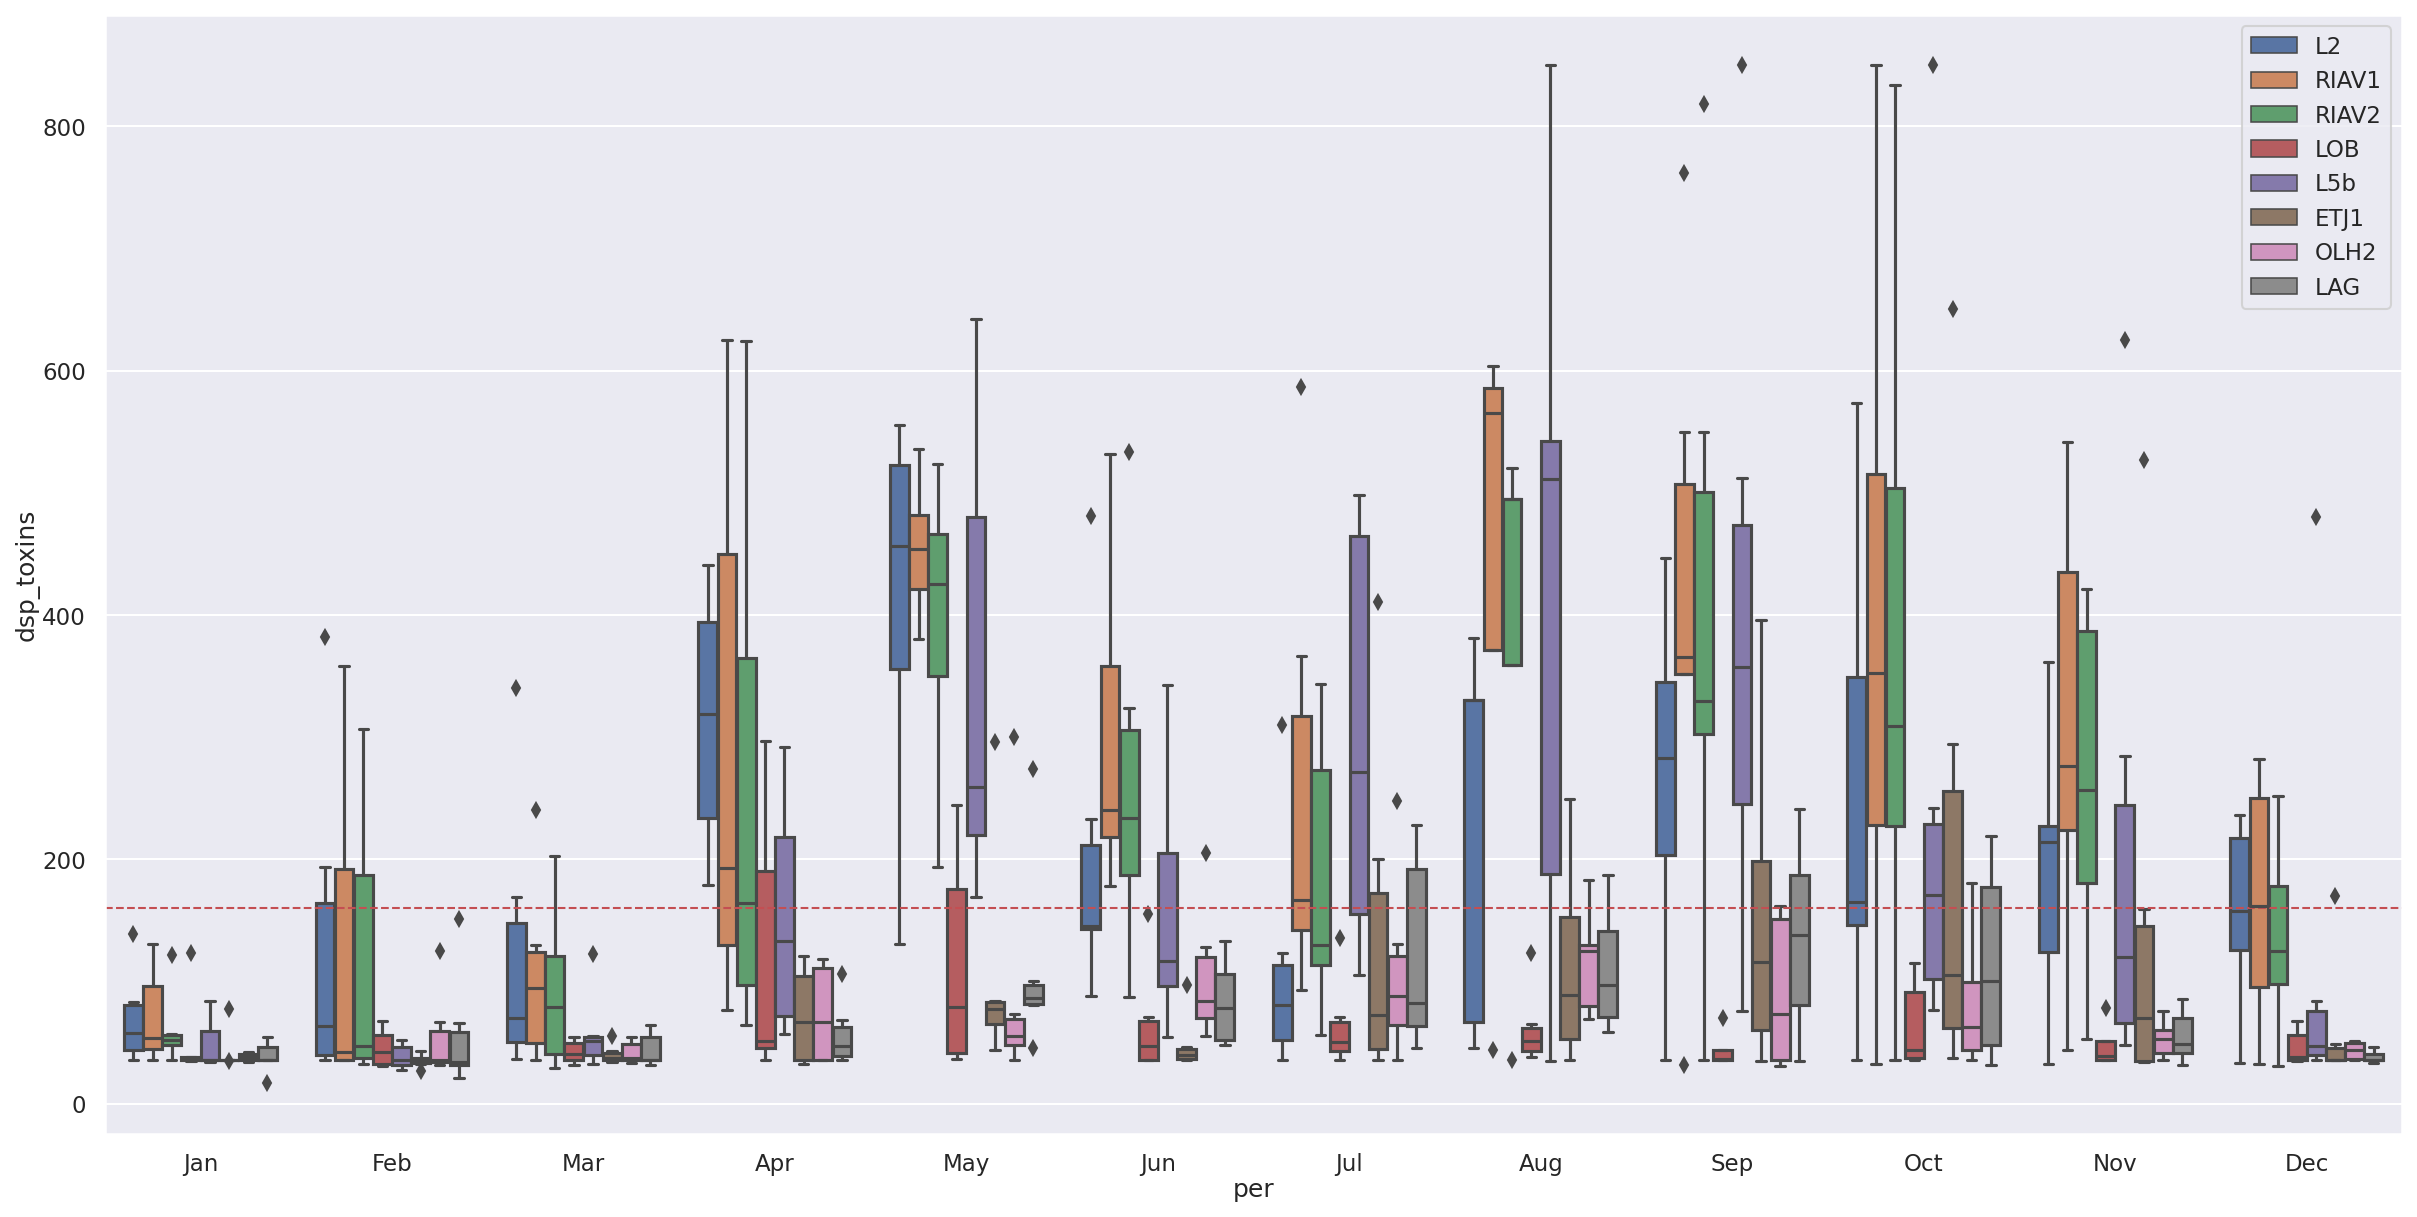

In [42]:
fig, axes = plt.subplots(1,1, figsize=(16,8), constrained_layout=True)
axes = boxplot_season_all(ts_month, areas, 'm', axes, merge_areas=False)
plt.show()

No handles with labels found to put in legend.


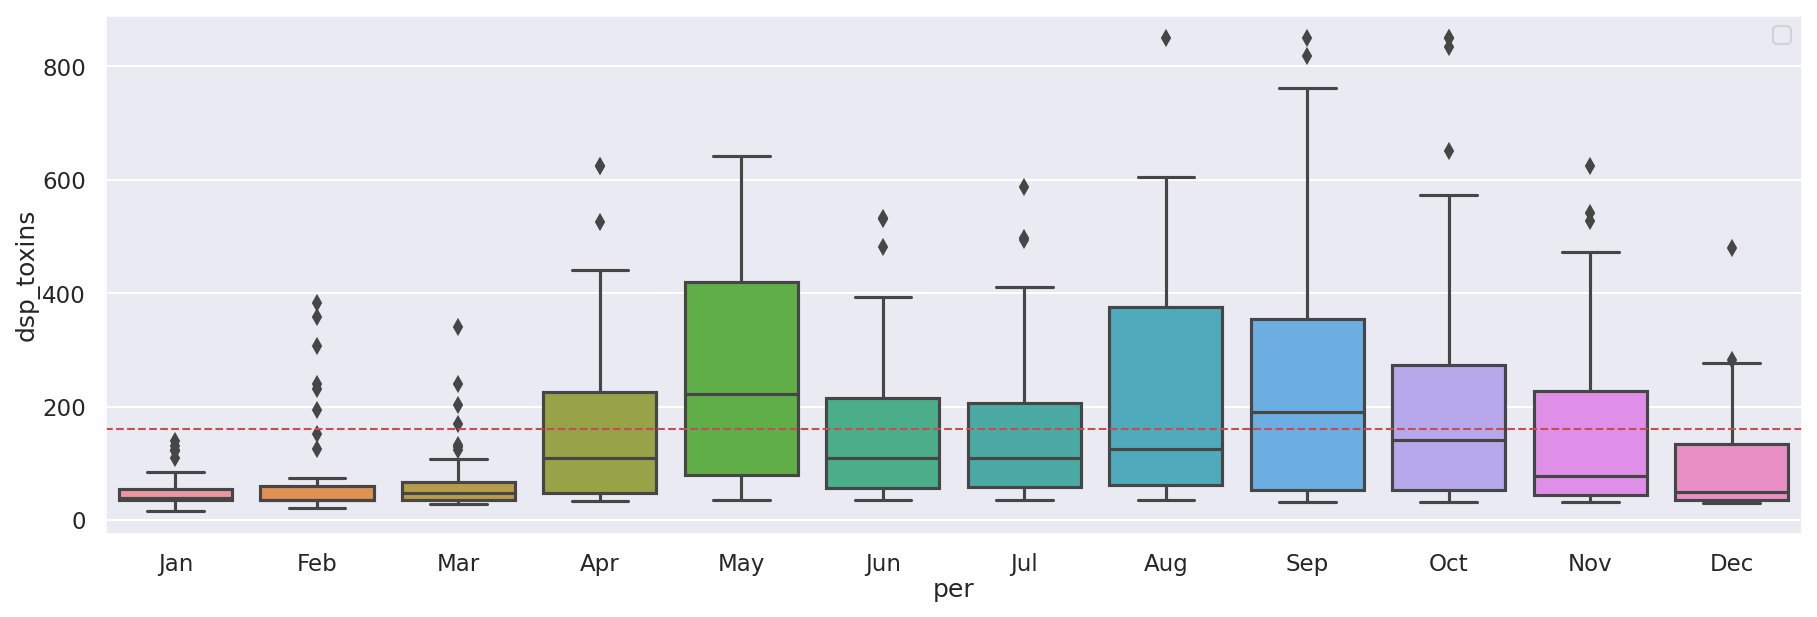

In [15]:
fig, axes = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
axes = boxplot_season_all(ts_month, areas, 'm', axes, merge_areas=True)
plt.show()

## Trend

### Separated

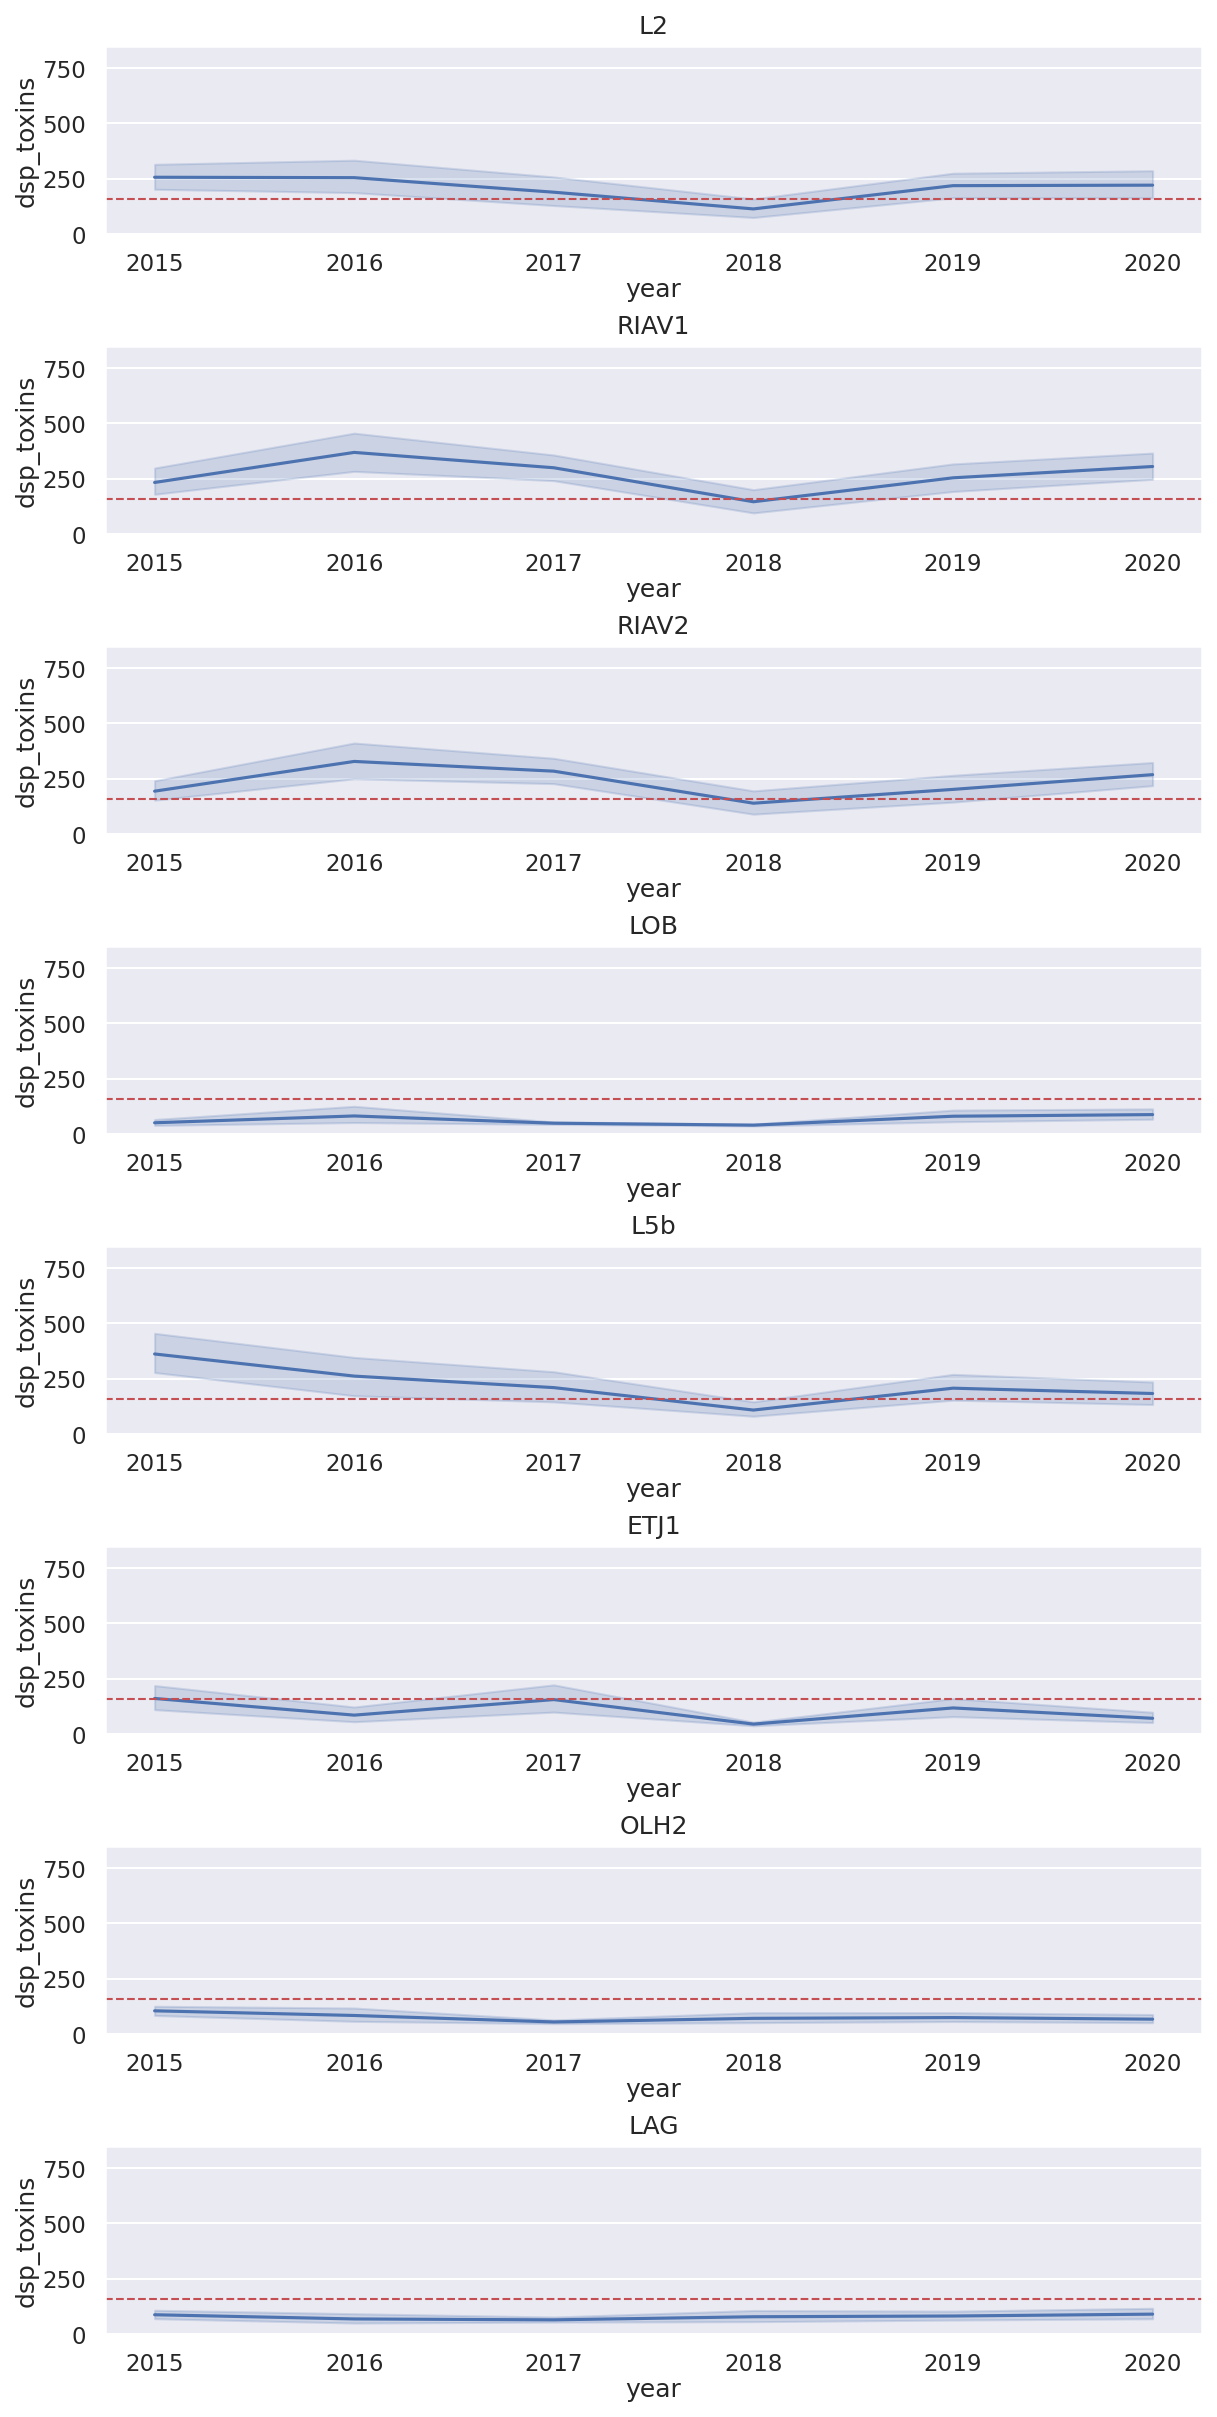

In [12]:
fig, axes = plt.subplots(len(ts_month),1, figsize=(8,16), constrained_layout=True)

for i in range(len(ts_month)):
    axes[i] = plot_trend(ts_week[i], axes[i])
    axes[i].set_ylim(0,850)
    axes[i].set_title(areas[i])
    axes[i].axhline(160, linestyle="--", color="r", linewidth=1)


plt.show()

### All

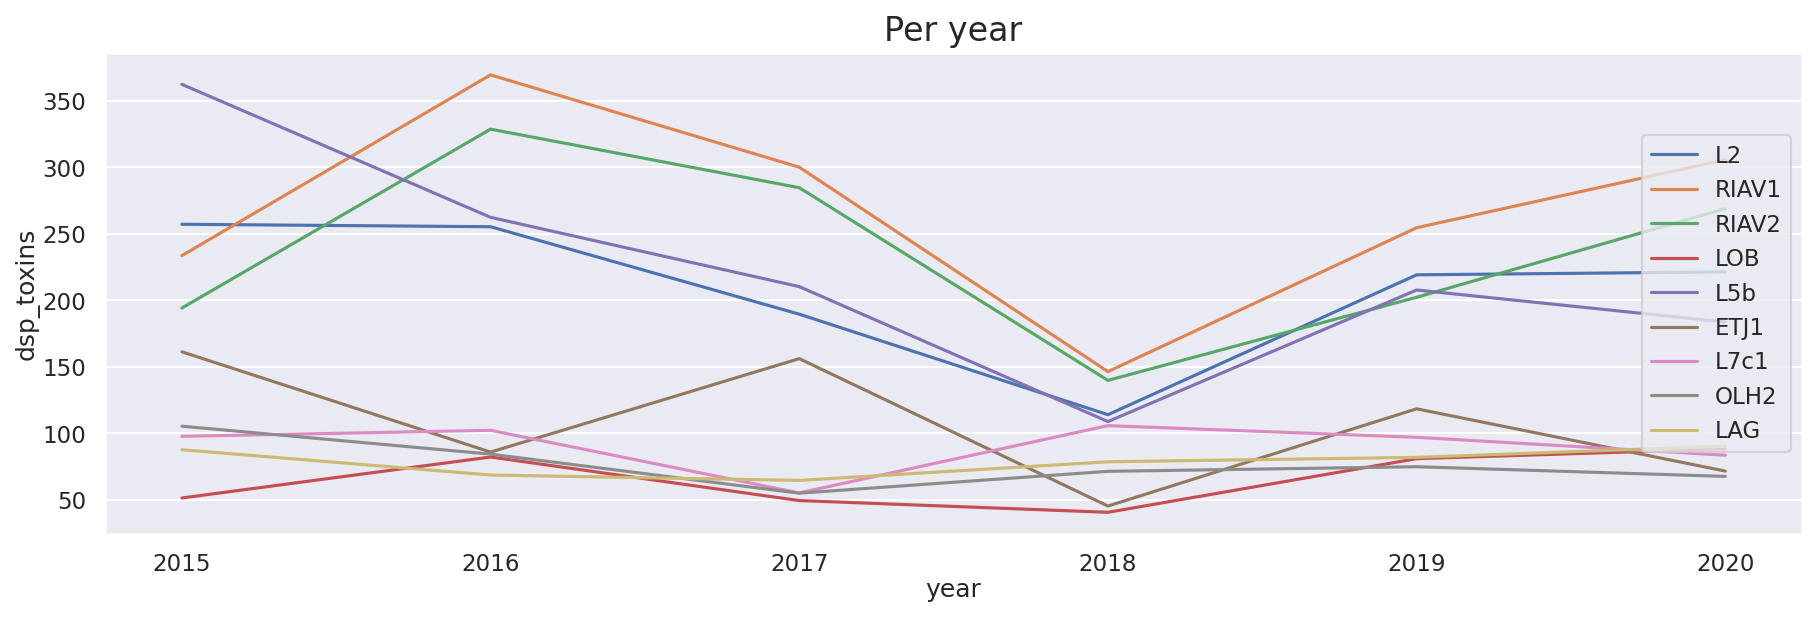

In [49]:
fig, axes = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
axes = plot_trend_all(ts_week, areas, axes, ci=False)
axes.legend(loc="center right")
plt.show()

### Region

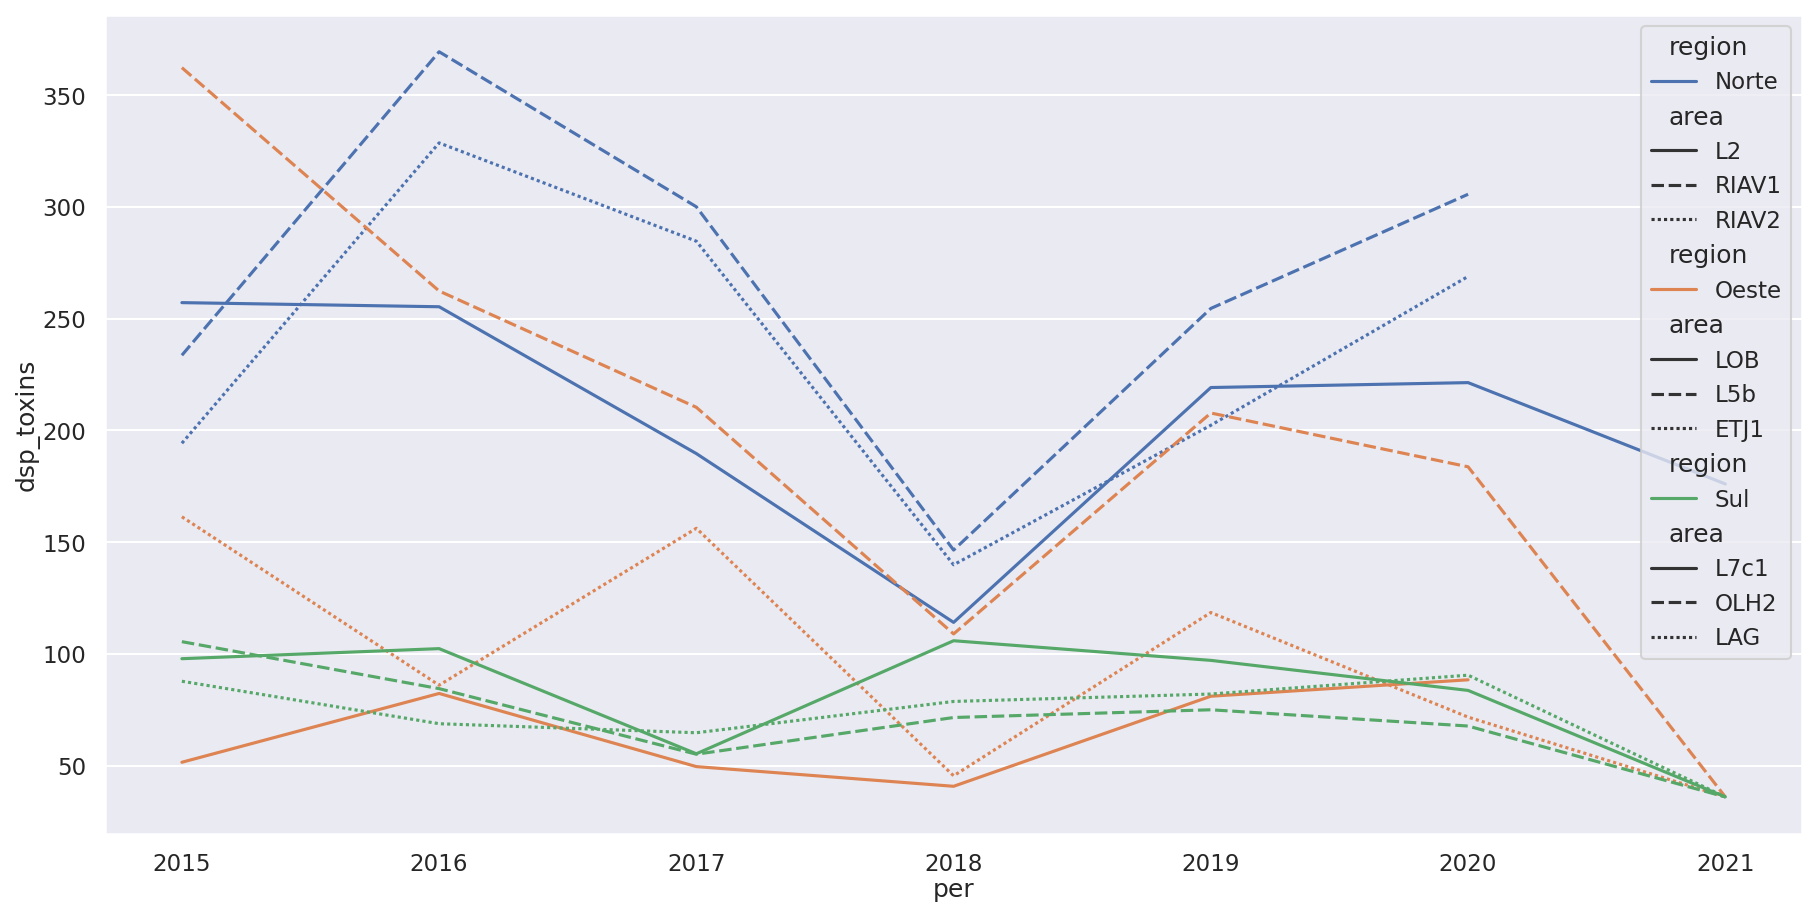

In [59]:
region_ts = pd.DataFrame(columns=ts_week[0].columns.tolist() + ["area","region"])
for ts, area in zip(ts_week, areas):
    t = ts.copy()
    t["area"] = area
    for r in regions:
        if area in regions[r]:
            t["region"] = r
    
    region_ts = region_ts.append(t)
region_ts['per'] = [int(d.strftime("%Y")) for d in region_ts.index]
region_ts = region_ts.reset_index(drop = True)

fig, ax = plt.subplots(1,1, figsize=(12,6), constrained_layout=True)
for i,region in enumerate(region_ts["region"].unique()):
    t = region_ts[region_ts["region"]==region]
    sns.lineplot(data=t, x="per", y="dsp_toxins", hue="region",style="area", ax=ax, ci=None, palette=[palette[i]])
    
plt.show()

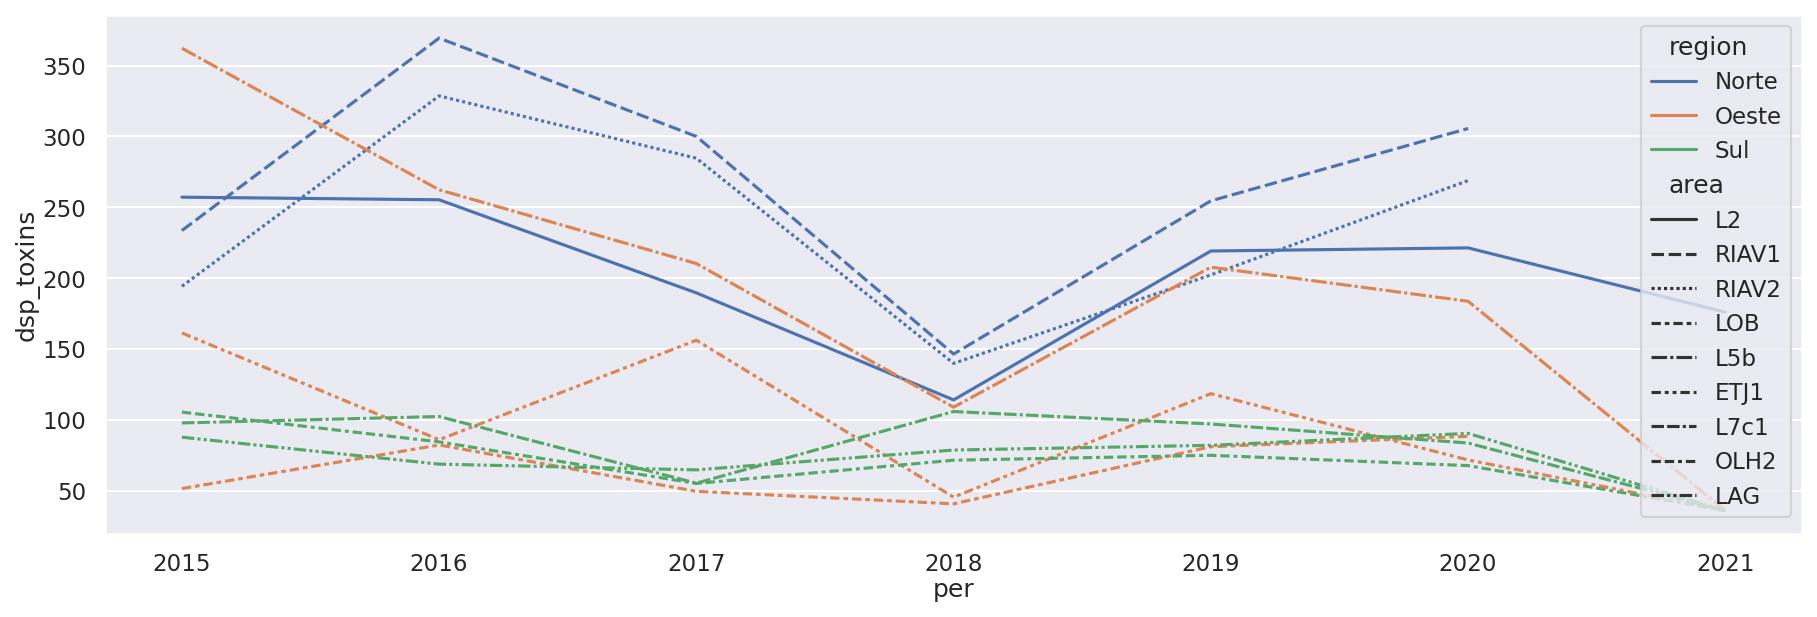

In [58]:
region_ts = pd.DataFrame(columns=ts_week[0].columns.tolist() + ["area","region"])
for ts, area in zip(ts_week, areas):
    t = ts.copy()
    t["area"] = area
    for r in regions:
        if area in regions[r]:
            t["region"] = r
    
    region_ts = region_ts.append(t)
region_ts['per'] = [int(d.strftime("%Y")) for d in region_ts.index]
region_ts = region_ts.reset_index(drop = True)

fig, ax = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
sns.lineplot(data=region_ts, x="per", y="dsp_toxins", hue="region", style="area",
             ax=ax, ci=None)
plt.show()

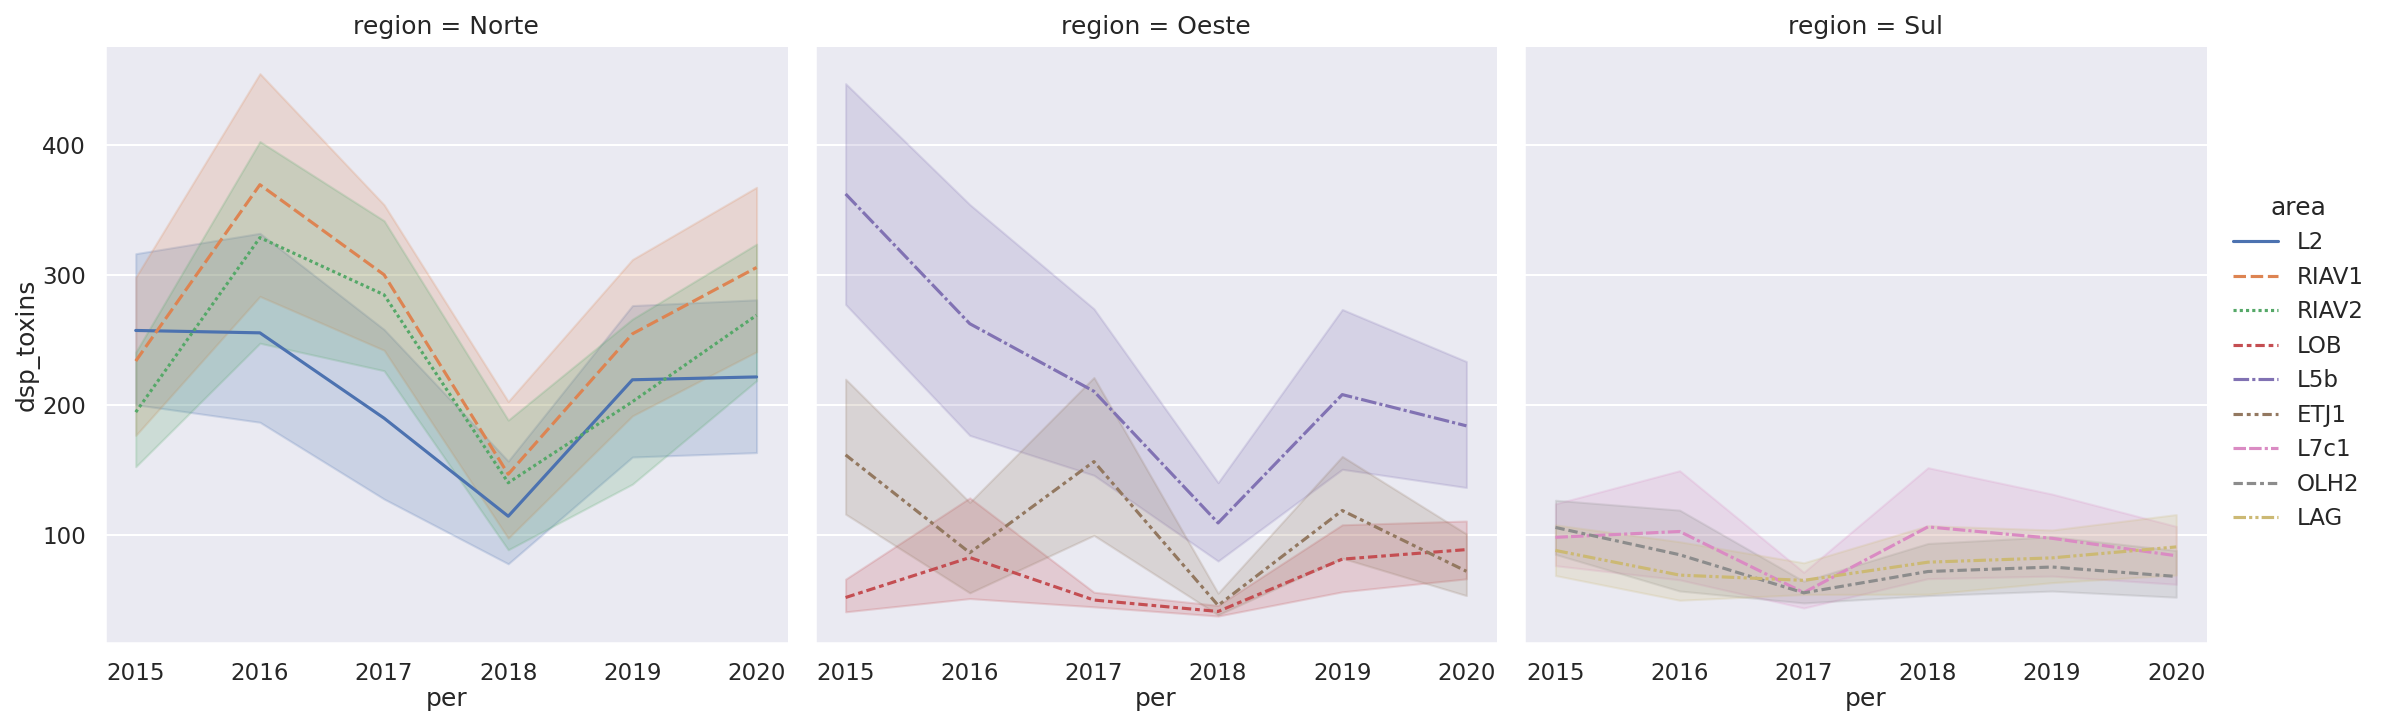

In [59]:
region_clipped = region_ts[ region_ts["per"] < 2021 ]
sns.relplot(
    data=region_clipped, x="per", y="dsp_toxins",
    col="region", hue="area", style="area",
    kind="line"
)
plt.show()